# NLP 기초 Assignment
## NLP 맛보기 - spam.csv를 가지고 유의미한 해석을 도출해주세요!

In [36]:
# 필요한 모듈 불러오기
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

## Load Data
- 보시면 아시다시피 spam.csv는 라벨이 있는 데이터입니다. 물론 7주차 주제가 텍스트 기초인만큼 텍스트만 활용하셔도 되고, 라벨까지 활용하셔서 모델을 돌려보셔도 좋습니다 :)

In [2]:
import os

path = '/home/user1/hyeokjong/NLP/assi/spam.csv'  # Path to corpus
spam = pd.read_csv('/home/user1/hyeokjong/NLP/assi/spam.csv')

In [3]:
spam.shape

(5572, 2)

In [4]:
# label
spam.v1

0        ham
1        ham
2       spam
3        ham
4        ham
        ... 
5567    spam
5568     ham
5569     ham
5570     ham
5571     ham
Name: v1, Length: 5572, dtype: object

In [5]:
# text
spam.v2

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: v2, Length: 5572, dtype: object

In [6]:
# example
spam.iloc[5]

v1                                                 spam
v2    FreeMsg Hey there darling it's been 3 week's n...
Name: 5, dtype: object

In [7]:
# labeling  
spam.v1 = (spam.v1 == 'spam')*1
spam

# spam = 1
# ham = 0

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [8]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [9]:
spam.v2.nunique()

# 중복 있음

5169

In [10]:
# 중복 제거
spam.drop_duplicates(subset = ['v2'], inplace = True)
spam.v2.nunique()

5169

In [11]:
print(f"There are {(spam.v1 == 1).sum()} spam and {(spam.v1 == 0).sum()} ham")
print(f"spam : {(spam.v1 == 1).sum() / ( (spam.v1 == 1).sum() + (spam.v1 == 0).sum() )}%")

There are 653 spam and 4516 ham
spam : 0.12633004449603405%


In [12]:
# 정규표현식 이용하여 문자가 아닌 것은 제거 and 소문자로

import re

def re_text(corpus):
    new = re.sub('[^a-zA-Z]', ' ', corpus).lower() 
    return new

spam.v2 = spam.v2.apply(re_text)

In [13]:
spam.v2

0       go until jurong point  crazy   available only ...
1                           ok lar    joking wif u oni   
2       free entry in   a wkly comp to win fa cup fina...
3       u dun say so early hor    u c already then say   
4       nah i don t think he goes to usf  he lives aro...
                              ...                        
5567    this is the  nd time we have tried   contact u...
5568                will    b going to esplanade fr home 
5569    pity    was in mood for that  so   any other s...
5570    the guy did some bitching but i acted like i d...
5571                           rofl  its true to its name
Name: v2, Length: 5169, dtype: object

## Tokenizing


In [14]:
nltk.download('punkt')
nltk.download('stopwords') 
stops = list(stopwords.words('english'))


[nltk_data] Downloading package punkt to /home/user1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/user1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
stops[:10]

# 이건 document에서 딱히 의미가 없음. 즉, train에 필요 없어서 이걸 제거해야합니다. 

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [17]:
tokens = []
for text in spam.v2 :             # 모든 문장마다
    words = word_tokenize(text)   # 토큰화
    words = [word for word in words if word not in stops]  # english_stops은 포함 안되게
    tokens.append(words)
spam.v2 = tokens    # change to tokenized sentence

In [18]:
spam[:5]

# 정규 표현식을 이용한 필요없는 문자제거
# 모두 소문자화
# 토큰화
# stop word 제거

,v1,v2
0,0,"[go, jurong, point, crazy, available, bugis, n..."
1,0,"[ok, lar, joking, wif, u, oni]"
2,1,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,"[u, dun, say, early, hor, u, c, already, say]"
4,0,"[nah, think, goes, usf, lives, around, though]"


## Embedding

- 수업에서 다룬 임베딩 방법에는 One-hot encoding, CBOW, Skip-gram, GloVe, FastText, EMlo가 있었습니다. 다양한 시도와 '비교' 결과를 함께 적어주세요! 파라미터를 조정해가는 과정도 해석에 도움이 될 수 있겠죠 :)

In [41]:
cv1 = CountVectorizer(max_features= 500, stop_words = 'english', lowercase= False)
cv2 = CountVectorizer(max_features= 500, stop_words = 'english', lowercase= False)
wc = WordCloud(background_color='white', max_words=100, width = 400, height = 300)

tokens_ham = sum(spam[spam.v1 == 0]['v2'], []) 
tokens_spam = sum(spam[spam.v1 == 1]['v2'], [])


tdm_ham = cv1.fit_transform(tokens_ham)
tdm_spam = cv2.fit_transform(tokens_spam)


In [42]:
word_counts_ham = pd.DataFrame({'words' : cv1.get_feature_names(),'counts' : tdm_ham.sum(axis = 0).flat})
word_counts_spam = pd.DataFrame({'words' : cv2.get_feature_names(),'counts' : tdm_spam.sum(axis = 0).flat})


In [43]:
word_counts_ham.sort_values('counts', ascending = False)

,words,counts
160,gt,288
244,lt,287
297,ok,255
156,got,239
212,know,225
...,...,...
206,join,11
209,kate,11
214,laptop,11
287,ni,11


In [45]:
word_counts_spam.sort_values('counts', ascending = False)

,words,counts
143,free,197
439,txt,141
448,ur,119
395,stop,114
251,mobile,111
...,...,...
43,callback,3
188,ibhltd,3
417,textoperator,3
350,review,3


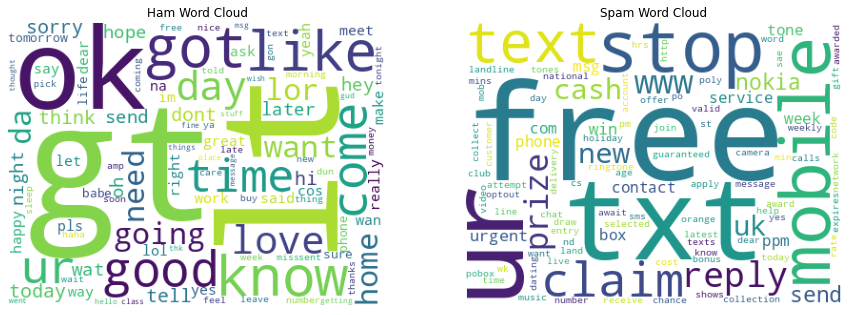

In [47]:

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.title('Ham Word Cloud')
count_dic = dict(zip(word_counts_ham['words'], word_counts_ham['counts']))
cloud = wc.generate_from_frequencies(count_dic)
plt.axis('off')
plt.imshow(cloud)
plt.subplot(1,2,2)
plt.title('Spam Word Cloud')
count_dic = dict(zip(word_counts_spam['words'], word_counts_spam['counts']))
cloud = wc.generate_from_frequencies(count_dic)
plt.axis('off')
plt.imshow(cloud)
plt.show()

## 본인이 도출해낸 해석을 적어주세요!

- 유사도, Wordcloud, 이진 분류 모델, Plot 뭐든 상관없으니 분명하고 인상적인 해석을 적어주시면 됩니다.